Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


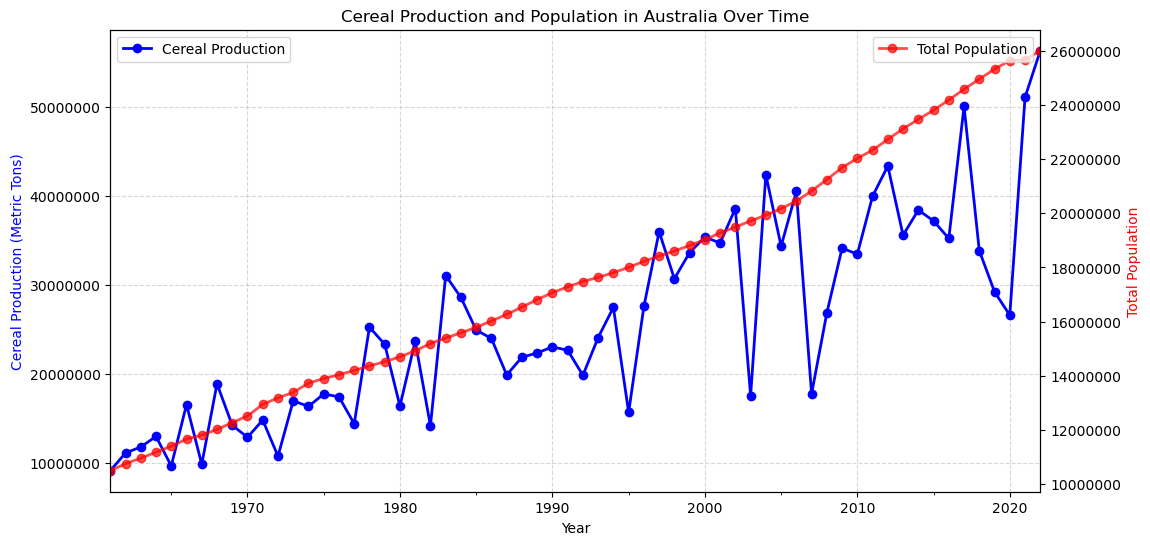

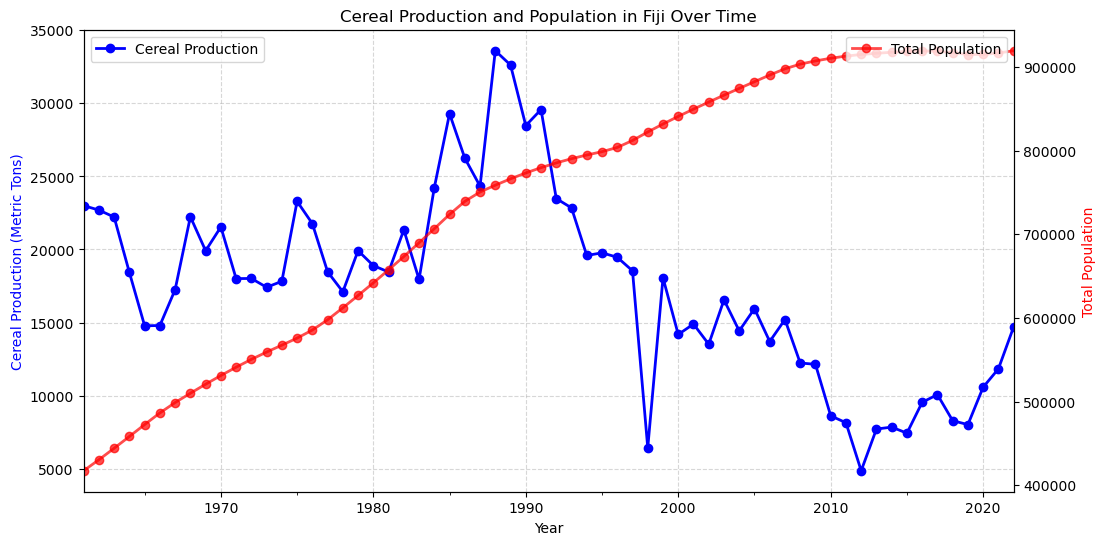

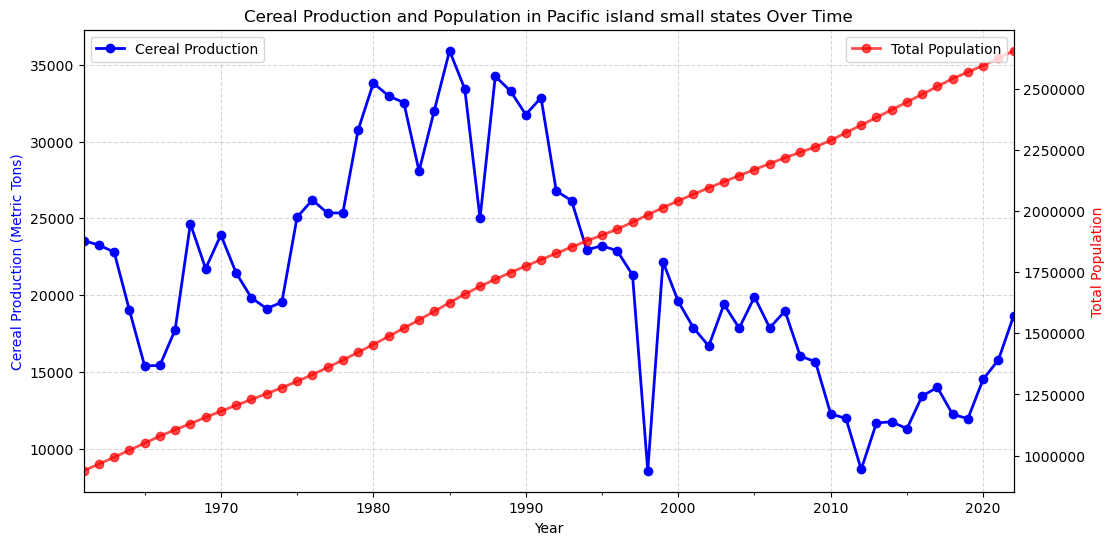

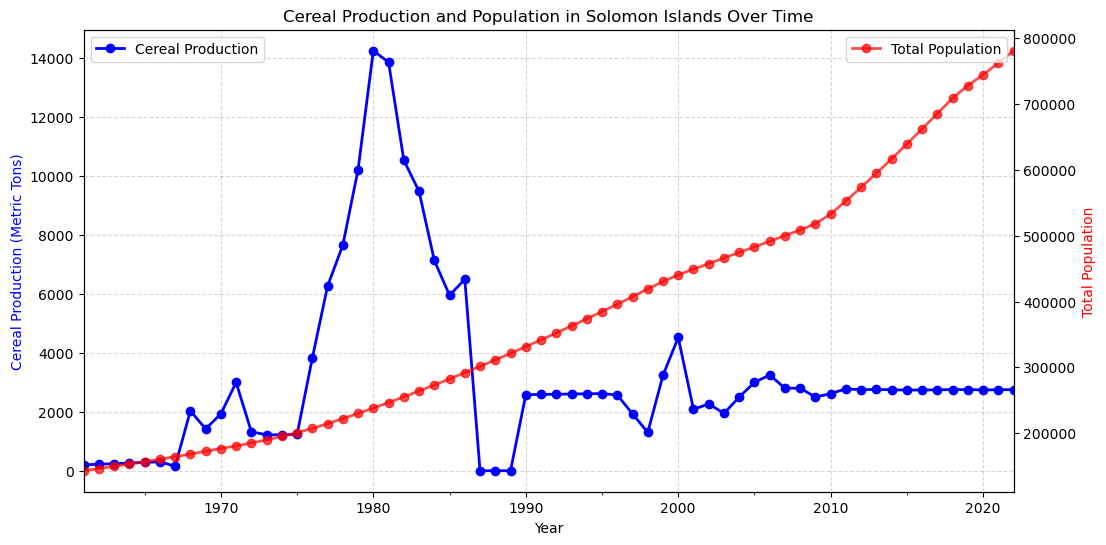

In [6]:
%pip install wbdata
%pip install plotly
import wbdata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import ScalarFormatter

#Plotting cereal production across various countries alongside their growth in population
#We will compare the graphs to see if it follows Malthus' theory
#We can also see how agricultural production differs across Pacific Island States
pd.options.plotting.backend = 'plotly'

#Create variables for Cereal Production and Population as a comparison
variable_labels = {
                "AG.PRD.CREL.MT":"Cereal Production (Metric Tons)",
                   "SP.POP.TOTL":"Total Population"
                  }

#I used these countries because they are Islands in the Pacific with data that go back to 1965
countries = ["AUS", "FJI", "SLB", "PSS"]

#Create dataframe that includes necessary variables
df1 = wbdata.get_dataframe(variable_labels, country = countries, parse_dates = True).dropna()

#Create two series to display cereal production and population
df1_cereal = df1["Cereal Production (Metric Tons)"].unstack(level="country").dropna()
df1_pop = df1["Total Population"].unstack(level="country").dropna()

pd.options.plotting.backend = 'matplotlib'

#Plot individual country comparisons
for country in df1_cereal.columns:
    fig, ax1 = plt.subplots(figsize=(12, 6)) #Configure for aesthetics
    ax2 = ax1.twinx()  #Create a second y-axis

    df1_cereal[country].plot(ax=ax1, marker="o", linewidth=2, label="Cereal Production", color='blue')
    df1_pop[country].plot(ax=ax2, marker="o", linewidth=2, alpha=0.7, label="Total Population", color='red')

    ax1.set_title(f"Cereal Production and Population in {country} Over Time")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Cereal Production (Metric Tons)", color='blue')
    ax2.set_ylabel("Total Population", color='red')

    #Get rid of scientific notation for each graph
    ax1.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax1.ticklabel_format(style="plain", axis="y")
    ax2.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax2.ticklabel_format(style="plain", axis="y")
    
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()

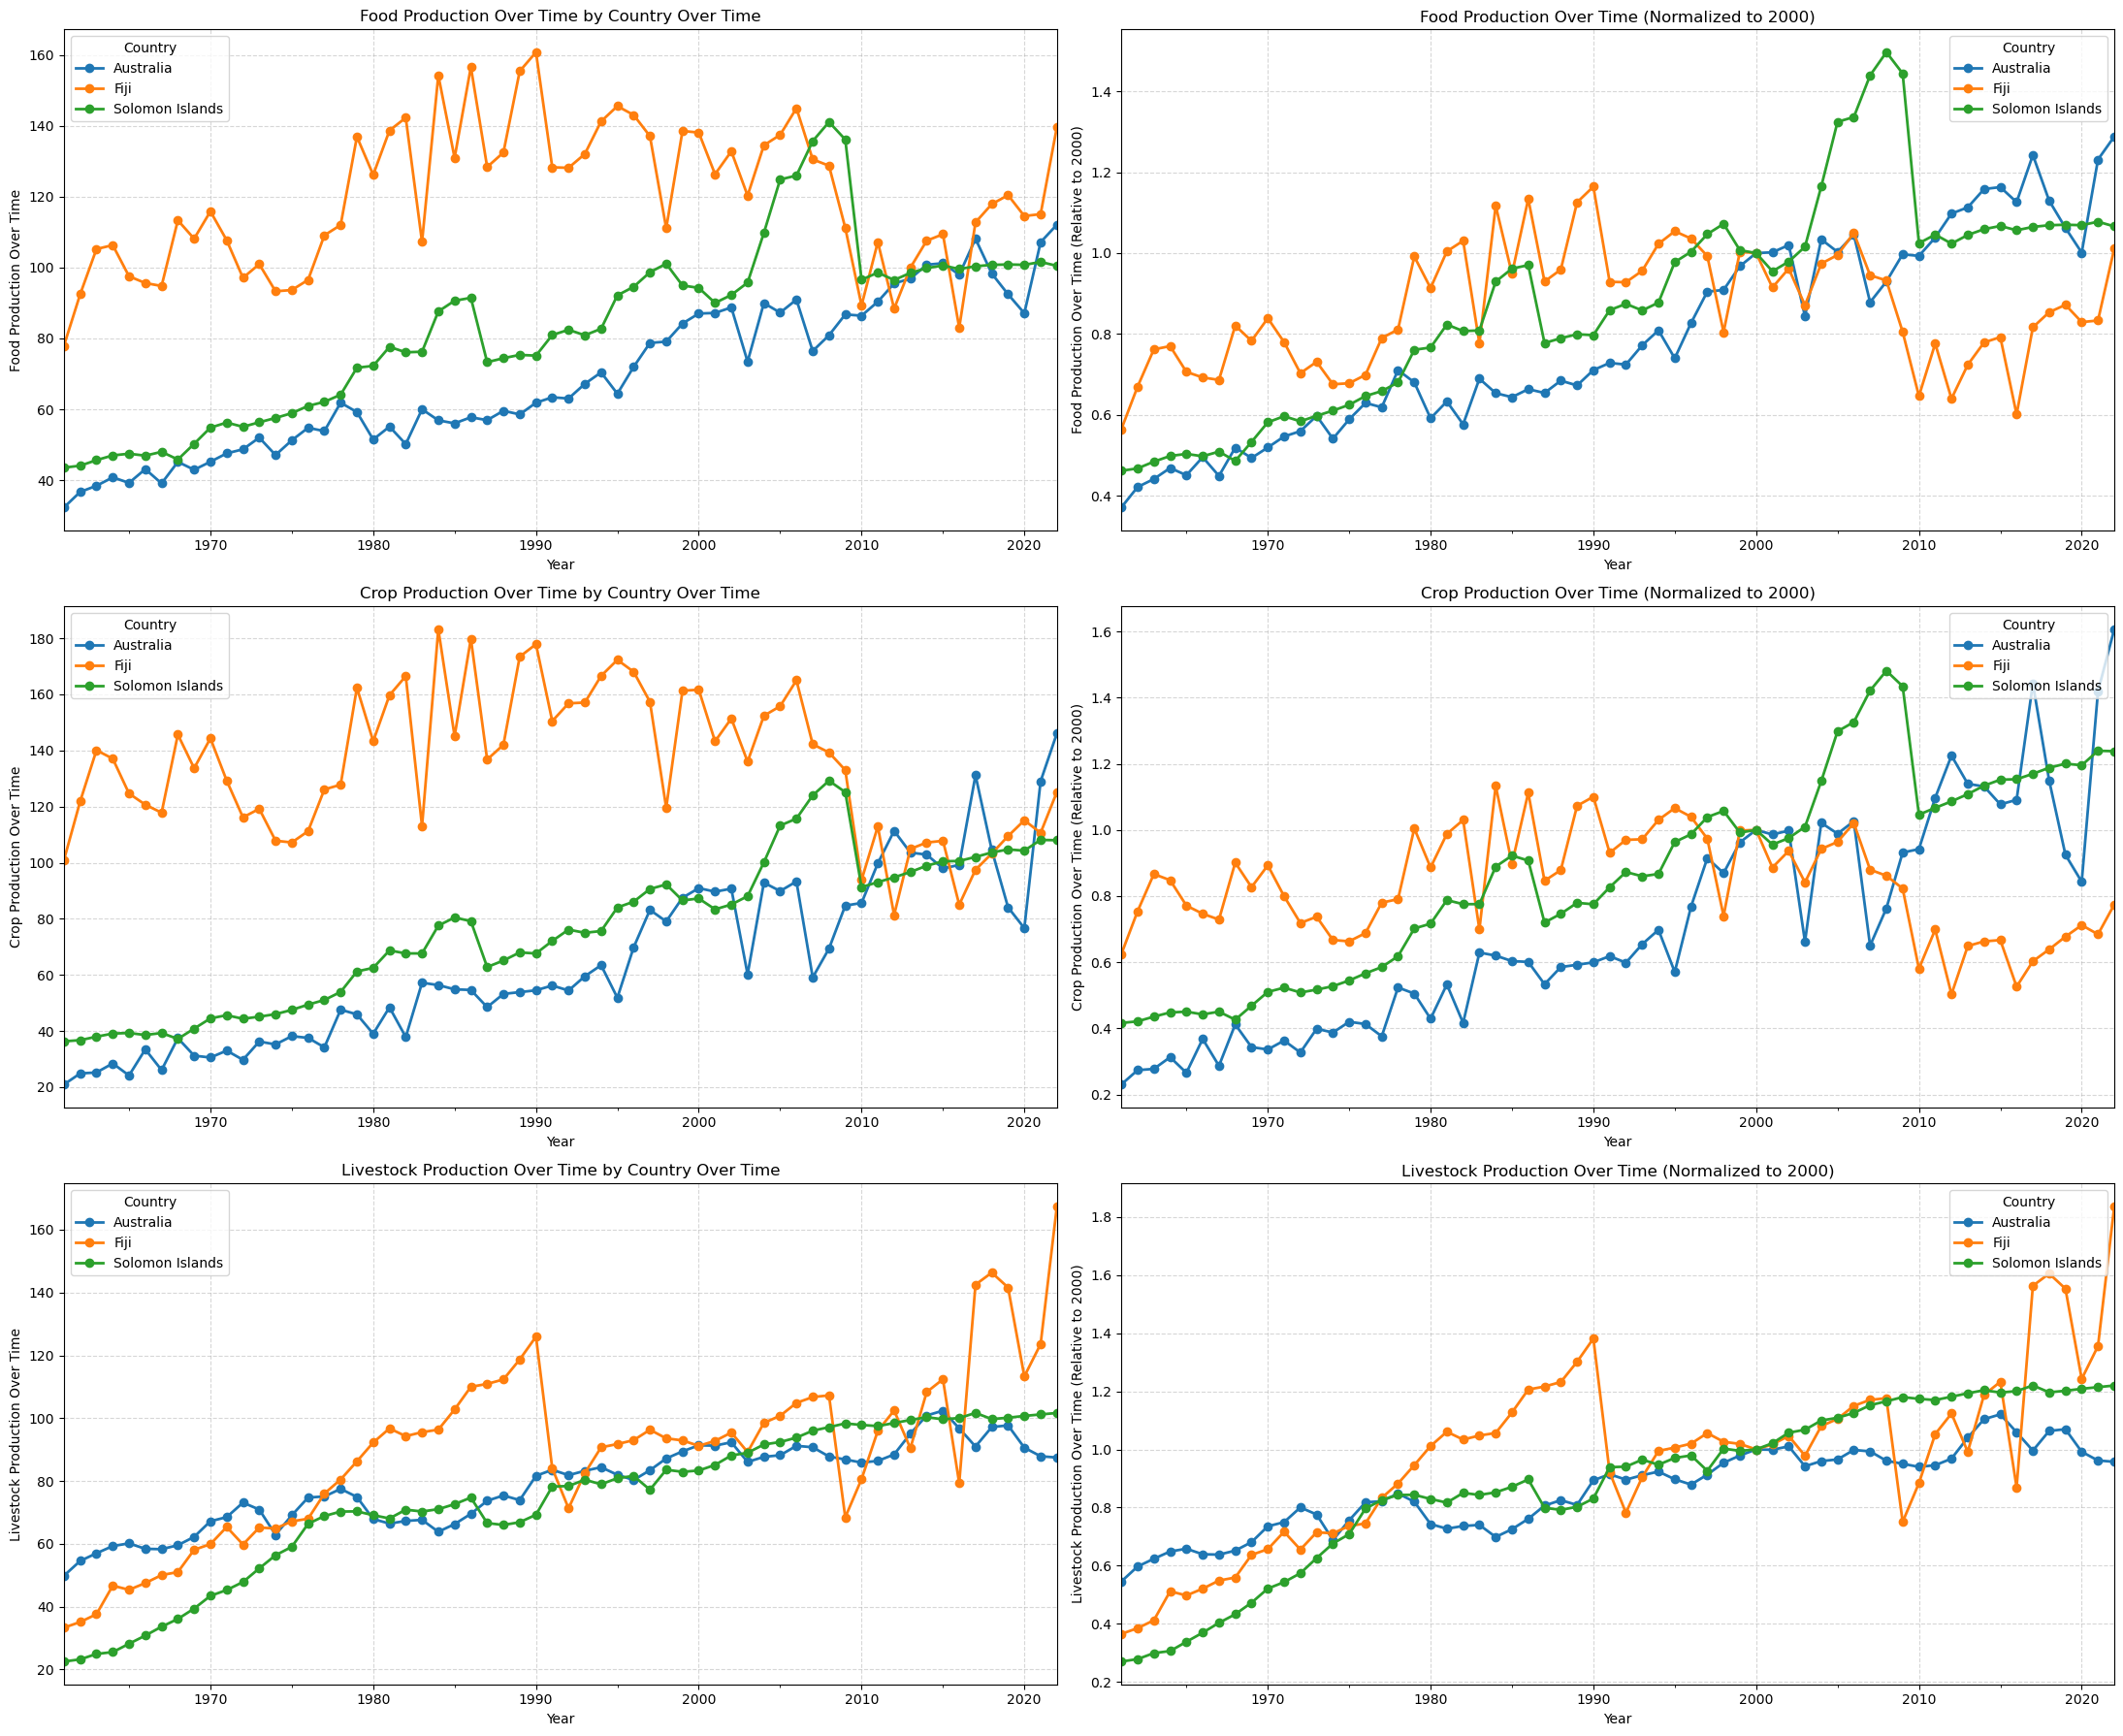

In [4]:
#Plot graphs for food production, crop production, and livestock for different states
#Normalized to one year (2000)
#Compare production across different countries

#Set backend for initial data retrieval
pd.options.plotting.backend = 'plotly'

#Define necessary variables
vars = {
    "AG.PRD.FOOD.XD":"Food Production",
    "AG.PRD.CROP.XD":"Crop Production",
    "AG.PRD.LVSK.XD":"Livestock Production"
}

#Get countries with enough data for food, crop, and livestock indexes
places = ["AUS", "FJI", "SLB"]

#Retrieve new data
df2 = wbdata.get_dataframe(vars, country=places, parse_dates=True).dropna()

#Get 3 series
df2_food = df2["Food Production"].unstack(level="country")
df2_crop = df2["Crop Production"].unstack(level="country")
df2_livestock = df2["Livestock Production"].unstack(level="country")

#Normalize data to year 2000
base_year = "2000-01-01" #Uses string as per dataframe

def normalize(df2, base_year):
    """Normalize a dataframe by a base year."""
    if base_year in df2.index:
        return df2 / df2.loc[base_year]
    else:
        print(f"Warning: Base year {base_year} not found in dataset.")
        return df2

#Create new series baseed on normalization
df2_food_norm = normalize(df2_food, base_year)
df2_crop_norm = normalize(df2_crop, base_year)
df2_livestock_norm = normalize(df2_livestock, base_year)

#Set backend for plotting
pd.options.plotting.backend = 'matplotlib'

#Plot raw vs normalized data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(22, 18))

plot_titles = [
    ("Food Production Over Time", df2_food, df2_food_norm),
    ("Crop Production Over Time", df2_crop, df2_crop_norm),
    ("Livestock Production Over Time", df2_livestock, df2_livestock_norm)
]

for i, (title, raw_data, norm_data) in enumerate(plot_titles):
    #Raw data plot
    raw_data.plot(ax=axes[i, 0], marker="o", linewidth=2)
    axes[i, 0].set_title(f"{title} by Country Over Time")
    axes[i, 0].set_xlabel("Year")
    axes[i, 0].set_ylabel(title)
    axes[i, 0].grid(True, linestyle="--", alpha=0.5)
    axes[i, 0].legend(title="Country", loc = "upper left")
    
    #Normalized data plot
    norm_data.plot(ax=axes[i, 1], marker="o", linewidth=2)
    axes[i, 1].set_title(f"{title} (Normalized to 2000)")
    axes[i, 1].set_xlabel("Year")
    axes[i, 1].set_ylabel(f"{title} (Relative to 2000)")
    axes[i, 1].grid(True, linestyle="--", alpha=0.5)
    axes[i, 1].legend(title="Country", loc = "upper right")

plt.tight_layout()
plt.show()

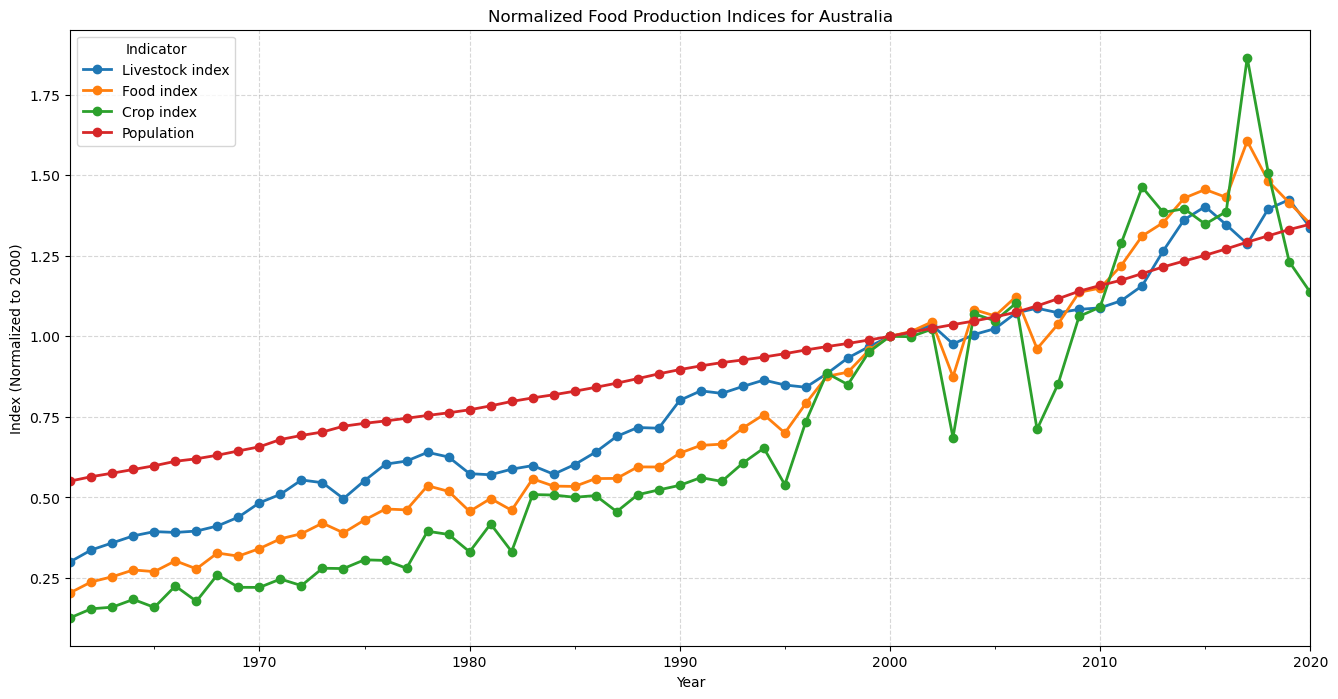

In [5]:
#Using Australia as a developed country to see if it fits Malthus' theory
#Normalizing to one year (2000)
#Seeing if it fits the world graph that we saw in class

#Define necessary variables
variables = {
    "AG.PRD.LVSK.XD": "Livestock index",
    "AG.PRD.FOOD.XD": "Food index",
    "AG.PRD.CROP.XD": "Crop index",
    "SP.POP.TOTL": "Population"
}

#Retrieve data only for Australia, given by 'AUS'
country = ["AUS"]

food = wbdata.get_dataframe(variables, country=country, parse_dates=True).dropna()

#Get Population series
Population = food["Population"]

#Weight indices by population
food_weighted = food.filter(regex='index$').multiply(Population, axis=0)

#Add back population for reference
food_weighted['Population'] = Population
food_weighted = food_weighted.replace(0, np.nan).dropna()

#Sort by date
food_weighted.sort_index(inplace=True)

#Normalize to 2000, meaning 2000 will equal 1 on our graphs
base_year = "2000-01-01"
if base_year in food_weighted.index:
    food_weighted = food_weighted / food_weighted.loc[base_year]
else:
    print(f"Warning: Base year {base_year} not found in dataset.")

#Remove data beyond 2020
food_weighted = food_weighted.query("date < '2021'")

food_weighted.plot(figsize=(16, 8), marker="o", linewidth=2, title="Normalized Food Production Indices for Australia")
plt.xlabel("Year")
plt.ylabel("Index (Normalized to 2000)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Indicator")
plt.show()

In [ ]:
#Compare to Malthus' graph/theory